## Evaluate the models obtained through training

Author: Ashwin Kumar (ashwin.kumar@vanderbilt.edu)  
Description: Create plots and conduct model evaluation on the models obtained from training.

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from model import *
from deepseg_gm import *
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import tensorflow as tf
from keras import Model
from keras.models import load_model
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [7]:
'''
Normalize volume to mean ~= 0 and std ~= 1
@input: volume to be normalized
@return: normalized volume
'''
def vol_norm(volume):
    volume_mean = volume.mean()
    volume_std = volume.std()

    volume -= volume_mean
    volume /= volume_std

    return volume

'''
Reshape the matrix and fix the dimensionality
@input 3D array
@output: concatenated array
'''
def shape_and_norm(arr, norm = True):
    arr_sampled = []
    for i in range(arr.shape[2]):
        if norm:
            arr_sampled.append(vol_norm(np.reshape(arr[:,:,i], (1, 256, 256))))
        else:
            # Just resample no norm 
            arr_sampled.append(np.reshape(arr[:,:,i], (1, 256, 256)))
    return np.concatenate(arr_sampled, axis=0)

Load test data

In [8]:
test_data = shape_and_norm(np.load('../data/test_data.npy'))
test_targets = shape_and_norm(np.load('../data/test_targets.npy'), False)

## Load in models and get predicted volumes

Load in the baseline model

In [16]:
bmodel = create_model(32)
bmodel.load_weights('challenge_model.hdf5')

#Calculate DSC
bmodel_preds = Model.predict(bmodel, test_data)

# Reshape and threshold predictions
bmodel_preds = threshold_predictions(np.reshape(bmodel_preds, (196, 256, 256)))

Load the GM Model with no pretraining

In [17]:
gm_no_pretrain = create_model(32)
gm_no_pretrain.load_weights('gm_model_no_pretrain/trained_17_epoch_aug.h5')

#Calculate model predictions
gm_no_pretrain_preds = Model.predict(gm_no_pretrain, test_data)

# Reshape and threshold predictions
gm_no_pretrain_preds = threshold_predictions(np.reshape(gm_no_pretrain_preds, (196, 256, 256)))

Load the GM Model with pretraining

In [18]:
gm_pretrain = create_model(32)
gm_pretrain.load_weights('gm_model_pretrain/trained_11_epoch_aug.h5')

#Calculate model predictions
gm_pretrain_preds = Model.predict(gm_pretrain, test_data)

# Reshape and threshold predictions
gm_pretrain_preds = threshold_predictions(np.reshape(gm_pretrain_preds, (196, 256, 256)))

Load the GM Augmented Model with no pretraining

In [19]:
gm_aug_no_pretrain = create_model(32)
gm_aug_no_pretrain.load_weights('gm_aug_model_no_pretrain/trained_14_epoch_aug.h5')

#Calculate model predictions
gm_aug_no_pretrain_preds = Model.predict(gm_aug_no_pretrain, test_data)

# Reshape and threshold predictions
gm_aug_no_pretrain_preds = threshold_predictions(np.reshape(gm_aug_no_pretrain_preds, (196, 256, 256)))

Load the GM Augmented Model with no pretraining

In [20]:
gm_aug_pretrain = create_model(32)
gm_aug_pretrain.load_weights('gm_aug_model_pretrain/trained_8_epoch_aug.h5')

#Calculate model predictions
gm_aug_pretrain_preds = Model.predict(gm_aug_pretrain, test_data)

# Reshape and threshold predictions
gm_aug_pretrain_preds = threshold_predictions(np.reshape(gm_aug_pretrain_preds, (196, 256, 256)))

## Evaluate Dice Coefficient

In [48]:
'''
Calculate dice coefficient between predicted model output and targets
@input: computed model predictions 
@input: test targets that function as ground truth
@return: numpy array with dice scores
'''
def dice_eval(model_preds, test_targets):
    dsc_scores = []
    for i in range(model_preds.shape[0]):
        dsc_scores.append(dice_coef(test_targets[i,:,:].astype('float64'), model_preds[i, :, :].astype('float64')).numpy())
    return np.asarray(dsc_scores)

In [140]:
#Compute Dice for Base Model
bmodel_dsc = dice_eval(bmodel_preds, test_targets)

#Compute Dice for GM no pretrain
gm_no_pretrain_dsc = dice_eval(gm_no_pretrain_preds, test_targets)

#Compute Dice for GM pretrain
gm_pretrain_dsc = dice_eval(gm_pretrain_preds, test_targets)

#Compute Dice for GM Aug no pretrain
gm_aug_no_pretrain_dsc = dice_eval(gm_aug_no_pretrain_preds, test_targets)

#Compute Dice for GM Aug pretrain
gm_aug_pretrain_dsc = dice_eval(gm_aug_pretrain_preds, test_targets)

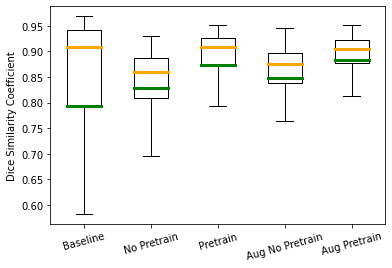

In [141]:
# Label to define models
labels = ['Baseline', 'No Pretrain', 'Pretrain', 'Aug No Pretrain', 'Aug Pretrain']
median_style = dict(linestyle='solid',linewidth=3.0, color='orange')
mean_style = dict(linestyle='solid',linewidth=3.0, color='green')
# box_style = dict(linestyle='solid',linewidth=4.0, color='black')
fig1, ax1 = plt.subplots()
# Create the boxplot
dsc_data = [bmodel_dsc, gm_no_pretrain_dsc, gm_pretrain_dsc, gm_aug_no_pretrain_dsc, gm_aug_pretrain_dsc]
ax1.set_ylabel('Dice Similarity Coefficient')
# ax1.set_ylim([0, 1])
ax1.boxplot(dsc_data, showfliers=False, meanline = True, showmeans=True, 
            medianprops=median_style, meanprops=mean_style)
ax1.set_xticklabels(labels, rotation=15) # Rotate the axes
plt.show()

## Evaluate Jaccard Index

In [133]:
'''
Return the Jaccard Score between the true and prediction array
@input: ground truth
@input: predicted values from model
@return: Jaccard score in numpy value
'''
def jaccard_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return ((intersection) / \
        (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)).numpy()

'''
Calculate dice coefficient between predicted model output and targets
@input: computed model predictions 
@input: test targets that function as ground truth
@return: numpy array with dice scores
'''
def jaccard_eval(model_preds, test_targets):
    jaccard_scores = []
    for i in range(model_preds.shape[0]):
        jaccard_scores.append(jaccard_score(test_targets[i,:,:].astype('float64'), model_preds[i, :, :].astype('float64')))
    return np.asarray(jaccard_scores)

In [142]:
#Compute Jaccard for Base Model
bmodel_jaccard = jaccard_eval(bmodel_preds, test_targets)

#Compute Jaccard for GM no pretrain
gm_no_pretrain_jaccard = jaccard_eval(gm_no_pretrain_preds, test_targets)

#Compute Jaccard for GM pretrain
gm_pretrain_jaccard = jaccard_eval(gm_pretrain_preds, test_targets)

#Compute Jaccard for GM Aug no pretrain
gm_aug_no_pretrain_jaccard = jaccard_eval(gm_aug_no_pretrain_preds, test_targets)

#Compute Jaccard for GM Aug pretrain
gm_aug_pretrain_jaccard = jaccard_eval(gm_aug_pretrain_preds, test_targets)

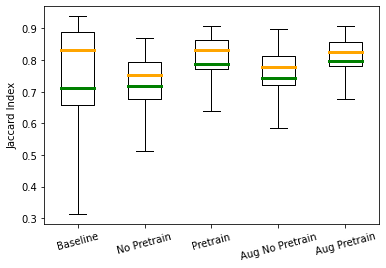

In [143]:
fig2, ax2 = plt.subplots()
# Create the boxplot
jaccard_data = [bmodel_jaccard, gm_no_pretrain_jaccard, gm_pretrain_jaccard, gm_aug_no_pretrain_jaccard, gm_aug_pretrain_jaccard]
ax2.set_ylabel('Jaccard Index')
# ax1.set_ylim([0, 1])
ax2.boxplot(jaccard_data, showfliers=False, meanline = True, showmeans=True, 
            medianprops=median_style, meanprops=mean_style)
ax2.set_xticklabels(labels, rotation=15) # Rotate the axes
plt.show()

## Evaluate True Positive Rate

In [148]:
'''
Calculate true positive rate between predicted model output and targets
@input: computed model predictions 
@input: test targets that function as ground truth
@return: numpy array with tpr scores
'''
def tpr_eval(model_preds, test_targets):
    tpr_scores = []
    for i in range(model_preds.shape[0]):
        tpr_scores.append(recall_score(test_targets[i,:,:].flatten(), model_preds[i, :, :].flatten()) * 100)
    return np.asarray(tpr_scores)

In [149]:
#Compute tpr for Base Model
bmodel_tpr = tpr_eval(bmodel_preds, test_targets)

#Compute tpr for GM no pretrain
gm_no_pretrain_tpr = tpr_eval(gm_no_pretrain_preds, test_targets)

#Compute tpr for GM pretrain
gm_pretrain_tpr = tpr_eval(gm_pretrain_preds, test_targets)

#Compute tpr for GM Aug no pretrain
gm_aug_no_pretrain_tpr = tpr_eval(gm_aug_no_pretrain_preds, test_targets)

#Compute tpr for GM Aug pretrain
gm_aug_pretrain_tpr = tpr_eval(gm_aug_pretrain_preds, test_targets)

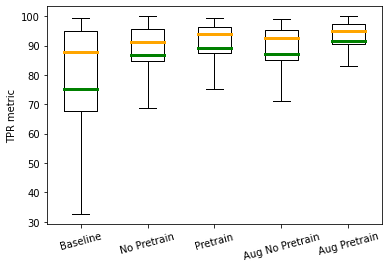

In [150]:
fig3, ax3 = plt.subplots()
# Create the boxplot
tpr_data = [bmodel_tpr, gm_no_pretrain_tpr, gm_pretrain_tpr, gm_aug_no_pretrain_tpr, gm_aug_pretrain_tpr]
ax3.set_ylabel('TPR metric')
# ax1.set_ylim([0, 1])
ax3.boxplot(tpr_data, showfliers=False, meanline = True, showmeans=True, 
            medianprops=median_style, meanprops=mean_style)
ax3.set_xticklabels(labels, rotation=15) # Rotate the axes
plt.show()

## Calculate False Positive, False Negative, True Positive, and True Negative

In [167]:
'''
Calculate tn, fp, fn, and tp between predicted model output and targets
@input: computed model predictions 
@input: test targets that function as ground truth
@return: four numpy array with the values
'''
def confusion_eval(model_preds, test_targets):
    tn_scores = []
    fp_scores = []
    fn_scores = []
    tp_scores = []
    for i in range(model_preds.shape[0]):
        tn, fp, fn, tp = confusion_matrix(test_targets[i,:,:].flatten(), model_preds[i, :, :].flatten()).ravel()
        tn_scores.append(tn)
        fp_scores.append(fp)
        fn_scores.append(fn)
        tp_scores.append(tp)
    return np.asarray(tn_scores), np.asarray(fp_scores), np.asarray(fn_scores), np.asarray(tp_scores)

In [168]:
#Compute confusion for Base Model
bmodel_tn, bmodel_fp, bmodel_fn, bmodel_tp  = confusion_eval(bmodel_preds, test_targets)

#Compute confusion for GM no pretrain
gm_no_pretrain_tn, gm_no_pretrain_fp, gm_no_pretrain_fn, gm_no_pretrain_tp  = confusion_eval(gm_no_pretrain_preds, test_targets)

#Compute confusion for GM pretrain
gm_pretrain_tn, gm_pretrain_fp, gm_pretrain_fn, gm_pretrain_tp  = confusion_eval(gm_pretrain_preds, test_targets)

#Compute confusion for GM Aug no pretrain
gm_aug_no_pretrain_tn, gm_aug_no_pretrain_fp, gm_aug_no_pretrain_fn, gm_aug_no_pretrain_tp = confusion_eval(gm_aug_no_pretrain_preds, test_targets)

#Compute confusion for GM Aug pretrain
gm_aug_pretrain_tn, gm_aug_pretrain_fp, gm_aug_pretrain_fn, gm_aug_pretrain_tp  = confusion_eval(gm_aug_pretrain_preds, test_targets)

## Evaluate Conformity Coefficient

In [191]:
'''
Return the Conformity Coefficient
@input: FP value
@input: FN Value
@input: TP Value
@return: Conformity Coefficient
'''
def conf_coef(fp, fn, tp):
    return ((1 - ((fp + fn) / tp)) * 100)

'''
Compute the conformity coeficient over the fp, fn, and tp array
@input: fp, fn, and tp arrays
@return: cc array
'''
def conf_eval(fp_array, fn_array, tp_array):
    cc_scores = []
    for i in range(len(fp_array)):
        if tp_array[i] != 0:
            cc_scores.append(conf_coef(fp_array[i], fn_array[i], tp_array[i]))
    return np.asarray(cc_scores)

In [192]:
#Compute cc for Base Model
bmodel_cc = conf_eval(bmodel_fp, bmodel_fn, bmodel_tp)

#Compute cc for GM no pretrain
gm_no_pretrain_cc = conf_eval(gm_no_pretrain_fp, gm_no_pretrain_fn, gm_no_pretrain_tp)

#Compute cc for GM pretrain
gm_pretrain_cc = conf_eval(gm_pretrain_fp, gm_pretrain_fn, gm_pretrain_tp)

#Compute cc for GM Aug no pretrain
gm_aug_no_pretrain_cc = conf_eval(gm_aug_no_pretrain_fp, gm_aug_no_pretrain_fn, gm_aug_no_pretrain_tp)

#Compute cc for GM Aug pretrain
gm_aug_pretrain_cc = conf_eval(gm_aug_pretrain_fp, gm_aug_pretrain_fn, gm_aug_pretrain_tp) 

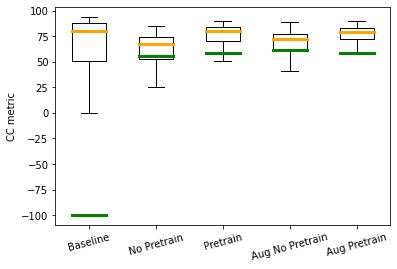

In [193]:
fig4, ax4 = plt.subplots()
# Create the boxplot
cc_data = [bmodel_cc, gm_no_pretrain_cc, gm_pretrain_cc, gm_aug_no_pretrain_cc, gm_aug_pretrain_cc]
ax4.set_ylabel('CC metric')
# ax1.set_ylim([0, 1])
ax4.boxplot(cc_data, showfliers=False, meanline = True, showmeans=True, 
            medianprops=median_style, meanprops=mean_style)
ax4.set_xticklabels(labels, rotation=15) # Rotate the axes
plt.show()

## Evaluate True Negative Rate

In [197]:
'''
Return the True Negative Rate
@input: TN and FP value
@return: True Negative Rate
'''
def tnr_rate(tn, fp):
    return ((tn / (tn + fp)) * 100)

'''
Compute the true negative rate over the tn and fp array
@input: tn and fp array
@return: True Negative Rate array
'''
def tnr_eval(tn_array, fp_array):
    tnr_scores = []
    for i in range(len(tn_array)):
        tnr_scores.append(tnr_rate(tn_array[i], fp_array[i]))
    return np.asarray(tnr_scores)


In [198]:
#Compute tnr for Base Model
bmodel_tnr = tnr_eval(bmodel_tn, bmodel_fp)

#Compute tnr for GM no pretrain
gm_no_pretrain_tnr = tnr_eval(gm_no_pretrain_tn, gm_no_pretrain_fp)

#Compute tnr for GM pretrain
gm_pretrain_tnr = tnr_eval(gm_pretrain_tn, gm_pretrain_fp)

#Compute tnr for GM Aug no pretrain
gm_aug_no_pretrain_tnr = tnr_eval(gm_aug_no_pretrain_tn, gm_aug_no_pretrain_fp)

#Compute tnr for GM Aug pretrain
gm_aug_pretrain_tnr = tnr_eval(gm_aug_pretrain_tn, gm_aug_pretrain_fp) 

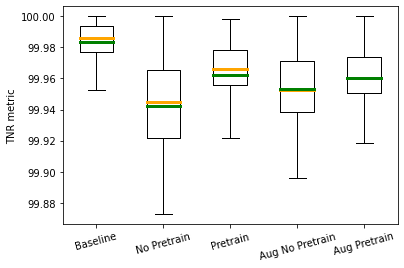

In [200]:
fig5, ax5 = plt.subplots()
# Create the boxplot
tnr_data = [bmodel_tnr, gm_no_pretrain_tnr, gm_pretrain_tnr, gm_aug_no_pretrain_tnr, gm_aug_pretrain_tnr]
ax5.set_ylabel('TNR metric')
# ax1.set_ylim([0, 1])
ax5.boxplot(tnr_data, showfliers=False, meanline = True, showmeans=True, 
            medianprops=median_style, meanprops=mean_style)
ax5.set_xticklabels(labels, rotation=15) # Rotate the axes
plt.show()

## Evaluate Positive Predictive Value

In [208]:
'''
Return the Positive Predictive Value
@input: TP and FP value
@return: Positive Predictive Value
'''
def ppv_rate(tp, fp):
    return ((tp / (tp + fp)) * 100)

'''
Compute the Positive Predictive Value over the tp and fp array
@input: tp and fp array
@return: Positive Predictive Value array
'''
def ppv_eval(tp_array, fp_array):
    ppv_scores = []
    for i in range(len(tp_array)):
        if tp_array[i] + fp_array[i] != 0:
            ppv_scores.append(ppv_rate(tp_array[i], fp_array[i]))
    return np.asarray(ppv_scores)

In [209]:
#Compute ppv for Base Model
bmodel_ppv = ppv_eval(bmodel_tp, bmodel_fp)

#Compute ppv for GM no pretrain
gm_no_pretrain_ppv = ppv_eval(gm_no_pretrain_tp, gm_no_pretrain_fp)

#Compute ppv for GM pretrain
gm_pretrain_ppv = ppv_eval(gm_pretrain_tp, gm_pretrain_fp)

#Compute ppv for GM Aug no pretrain
gm_aug_no_pretrain_ppv = ppv_eval(gm_aug_no_pretrain_tp, gm_aug_no_pretrain_fp)

#Compute ppv for GM Aug pretrain
gm_aug_pretrain_ppv = ppv_eval(gm_aug_pretrain_tp, gm_aug_pretrain_fp) 

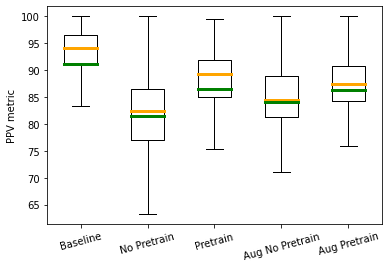

In [210]:
fig6, ax6 = plt.subplots()
# Create the boxplot
ppv_data = [bmodel_ppv, gm_no_pretrain_ppv, gm_pretrain_ppv, gm_aug_no_pretrain_ppv, gm_aug_pretrain_ppv]
ax6.set_ylabel('PPV metric')
# ax1.set_ylim([0, 1])
ax6.boxplot(ppv_data, showfliers=False, meanline = True, showmeans=True, 
            medianprops=median_style, meanprops=mean_style)
ax6.set_xticklabels(labels, rotation=15) # Rotate the axes
plt.show()